In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pybedtools
import pickle
from matplotlib_venn import venn3, venn3_circles,venn3_unweighted,venn2
import seaborn as sns
from pandas import DataFrame
import os
import csv
import matplotlib.patches as patches
import pysam

# Initialization 

In [3]:
methods=["Tophat","STAR","HISAT2"]
sample="NA12878"
reliable_est_bed="/path/to/reliable/EST/junctions.bed"

# Predictions

In [4]:
bed_files={'Tophat':'/path/to/TopHat/junctions.bed',
           'STAR':'/path/to/STAR/SJ.out.tab',
           'HISAT2':'/path/to/HISAT/splicesites.txt',
        }
bam_files={'Tophat':'/path/to/TopHat/alignments.bam',
           'STAR':'/path/to/STAR/alignments.bam',
           'HISAT2':'/path/to/HISAT2/alignments.bam',
            }


# Functions

In [5]:
def find_stats(bamfile,statfile):
    sam_file = pysam.Samfile(bamfile, "rb")
    seq={"1":[],"2":[]}
    current_qname=""
    uniqmap_uniqmap=0
    uniqmap_multimap=0
    multimap_multimap=0
    uniqmap_unmap=0
    multimap_unmap=0
    unmap_unmap=0
    cnts=0
    for line in sam_file:
        qname=line.qname
        if current_qname=="":
            current_qname=qname 
        if qname!=current_qname:
            uniqed_multi_un={}
            for fs in ["1","2"]:
                NHs=map(lambda x:x[1],seq[fs])
                if len(set(NHs))==1:
                    NH=NHs[0]
                    if NH==1:
                        uniqed_multi_un[fs]=0
                    elif NH==-1:
                        uniqed_multi_un[fs]=2
                    else:
                        uniqed_multi_un[fs]=1
            if uniqed_multi_un["1"]==0 and uniqed_multi_un["2"]==0:
                uniqmap_uniqmap+=1 
            elif (uniqed_multi_un["1"]==0 and uniqed_multi_un["2"]==1) or (
                uniqed_multi_un["1"]==1 and uniqed_multi_un["2"]==0):
                uniqmap_multimap+=1 
            elif (uniqed_multi_un["1"]==1 and uniqed_multi_un["2"]==1):
                multimap_multimap+=1 
            elif (uniqed_multi_un["1"]==0 and uniqed_multi_un["2"]==2) or (
                uniqed_multi_un["1"]==2 and uniqed_multi_un["2"]==0):
                uniqmap_unmap+=1 
            elif (uniqed_multi_un["1"]==1 and uniqed_multi_un["2"]==2) or (
                uniqed_multi_un["1"]==2 and uniqed_multi_un["2"]==1):
                multimap_unmap+=1 
            elif (uniqed_multi_un["1"]==2 and uniqed_multi_un["2"]==2):
                unmap_unmap+=1 
            else:
                print "ERRR3 ", line
                aaaa
            current_qname=qname
            seq={"1":[],"2":[]}

        flag=np.binary_repr(line.flag,12)
        tags=dict(line.get_tags())
        NH=-1 if "NH" not in tags else tags["NH"]
        mpd=flag[-3]=="0"
        pmpd=flag[-4]=="0"
        first=flag[-7]=="1"
        second=flag[-8]=="1"
        if not (first ^ second):
            print "ERRR1 ", line
            aaaa

        if (not mpd) and NH>0:
            print "ERRR1 ", line
            aaaa

        fs="1" if first else "2"
        seq[fs].append([flag,NH,mpd,pmpd])
        cnts+=1
    with open(statfile, 'wb') as csvfile:
        spamwriter = csv.writer(csvfile, delimiter='\t',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        spamwriter.writerow(["uniqmap_uniqmap", "uniqmap_multimap", "multimap_multimap", "uniqmap_unmap", "multimap_unmap", "unmap_unmap","total","cnts"])
        spamwriter.writerow([uniqmap_uniqmap, uniqmap_multimap, multimap_multimap, uniqmap_unmap, multimap_unmap, unmap_unmap,
                             sum([uniqmap_uniqmap, uniqmap_multimap, multimap_multimap, uniqmap_unmap, multimap_unmap, unmap_unmap]),cnts])

def find_matchstats(bamfile,matchstatfile):
    sam_file = pysam.Samfile(bamfile, "rb")
    match_stats={}
    for line in sam_file:
        if line.cigar:
            codes={}
            for k,v in line.cigar:
                if k not in codes:
                    codes[k]=0
                codes[k]+=v
            for k,v in codes.iteritems():
                if k not in match_stats:
                    match_stats[k]={}
                if v not in match_stats[k]:
                    match_stats[k][v]=0
                match_stats[k][v]+=1
    pickle.dump(match_stats,open(matchstatfile,"w"))
        
def find_NMstats(bamfile,NMstatfile):
    sam_file = pysam.Samfile(bamfile, "rb")
    NM_stats={}
    for line in sam_file:
        unmapped=(line.flag/4)%2==1
        if unmapped:
            continue
        tags=dict(line.tags)
        if "NM" in tags:
            nm=tags["NM"]
            if nm not in NM_stats:
                NM_stats[nm]=0
            NM_stats[nm]+=1
        elif "nM" in tags:
            nm=tags["nM"]
            if nm not in NM_stats:
                NM_stats[nm]=0
            NM_stats[nm]+=1
        else:
            print tags
            aaaa
    pickle.dump(NM_stats,open(NMstatfile,"w"))


# Analysis

In [6]:
est_junctions_reliable=pybedtools.BedTool(reliable_est_bed)

In [7]:
all_beds={}
for method,bedfile in bed_files.iteritems():
    mybed=pybedtools.BedTool(bedfile)
    if method == "STAR":
        mybed=mybed.filter(lambda x: (int(x[2])-int(x[1]))>1).each(lambda x:[x[0],int(x[1])+1,x[2]]).saveas()
    elif method == "HISAT2":
        mybed=mybed.each(lambda x:[x[0],int(x[1])+1,x[2]]).saveas()  
    elif method == "Tophat":
        mybed=mybed.each(lambda x:[x[0],int(x[1])+int(x[10].split(",")[0]),int(x[2])-int(x[10].split(",")[1])]).saveas()  
    all_beds[method]=mybed.each(lambda x:["chr%s"%x[0],x[1],x[2]]).saveas()


In [8]:
for method,bamfile in bam_files.iteritems():
    statfile=bamfile+".mystats"
    if os.path.exists(bamfile):
        if not os.path.exists(statfile):
            find_stats(bamfile,statfile)

In [9]:
for method,bamfile in bam_files.iteritems():
    statfile=bamfile+".mystats_match"
    if os.path.exists(bamfile):
        if not os.path.exists(statfile):
            find_matchstats(bamfile,statfile)

In [10]:
for method,bamfile in bam_files.iteritems():
    statfile=bamfile+".mystats_NM"
    if os.path.exists(bamfile):
        if not os.path.exists(statfile):
            print sample,method
            find_NMstats(bamfile,statfile)

In [11]:
def parse_my_stats(stat_file):
    mystats={}
    with open(stat_file, 'r') as csv_f:
        spamreader = csv.reader(csv_f, delimiter='\t', quotechar='|')
        cnt=0
        for row in spamreader:
            if cnt==0:
                keys=row
                cnt=1
            else:
                vals=row
                mystats={x[0]:int(x[1]) for x in zip(keys,vals)}
                return mystats
    return {}

In [12]:
alignment_stats={}
for method,bed in all_beds.iteritems():
    alignment_stats[method]={}
    L=len(bed)
    L_est_reliable=len(bed.intersect(est_junctions_reliable,f=0.99,u=True,r=True))
    alignment_stats[method].update({"n_junctions":L,\
                                            "n_est_reliable":L_est_reliable,\
                                            "r_est_reliable":round(float(L_est_reliable)/float(L),2)})

In [13]:
for method,bamfile in bam_files.iteritems():
    statfile=bamfile+".mystats"
    mystats=parse_my_stats(statfile)
    alignment_stats[method].update(mystats)


In [14]:
for method,bamfile in bam_files.iteritems():
    statfile=bamfile+".mystats_match"
    mystats=pickle.load(open(statfile))
    alignment_stats[method].update({"match_stats":mystats})

In [15]:
for method,bamfile in bam_files.iteritems():
    statfile=bamfile+".mystats_NM"
    mystats=pickle.load(open(statfile))
    alignment_stats[method].update({"NM":mystats})


In [16]:
intersect_3methods={i:{} for i in range(8)}
for iii in range(8):
    if iii==0:
        continue
    i=iii%2
    j=(iii/2)%2
    k=(iii/4)%2
    bed1=all_beds[methods[0]]
    bed2=all_beds[methods[1]]
    bed3=all_beds[methods[2]]
    if i==1:
        bed=bed1
    elif j==1:
        bed=bed2
    elif k==1:
        bed=bed3
    bed=bed.intersect(bed1,f=0.99,u=True if i==1 else False,v=True if i==0 else False,r=True)
    bed=bed.intersect(bed2,f=0.99,u=True if j==1 else False,v=True if j==0 else False,r=True)
    bed=bed.intersect(bed3,f=0.99,u=True if k==1 else False,v=True if k==0 else False,r=True)
    L=len(bed)
    L_est_reliable=len(bed.intersect(est_junctions_reliable,f=0.99,u=True,r=True))
    intersect_3methods[iii].update({"n_junctions":L,\
                                    "n_est_reliable":L_est_reliable,\
                                    "r_est_reliable":round(float(L_est_reliable)/float(L),2)})

## Plots

## junction validation

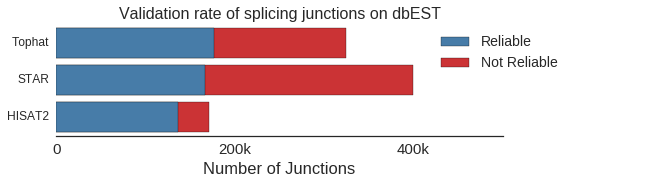

In [17]:
sns.set(style="white",font_scale=1.5)    
fig, ax = plt.subplots(figsize=(8,2))
bin_labels=["Reliable" , "Not Reliable"]
A=[]
B=[]
res=[]
labels=[]
my_colors=sns.color_palette("Set1",n_colors=10)
for jjj,method in enumerate(methods):
    A.append(alignment_stats[method]["n_junctions"])
    B.append(alignment_stats[method]["n_est_reliable"])
    labels.append(method)
res.append(np.array(A))
res.append(np.array(B))
my_data=DataFrame(np.array(res).transpose(),index=labels,columns=bin_labels[::-1])
for ii,b in enumerate(bin_labels[::-1]):
    cg=sns.barplot(data=my_data,x=b,y=labels,label=b, color=my_colors[ii],ax=ax)
for i,ytick in enumerate(cg.get_yticklabels()):
    ytick.set_fontsize(12)
ax.set_xlabel("Number of Junctions")
ax.set_xticks(range(0,600000,200000))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(["%sk"%(x/1000) if x>0 else "0" for x in range(0,600000,200000)])

ax.set_xlim([0,500000])
ax.set_title("Validation rate of splicing junctions on dbEST",fontsize=16)
sns.despine(left=True)    
handles, labels = ax.get_legend_handles_labels()
# reverse the order
ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(0.85, 0.65, 0.5, .3), 
      loc=1,ncol=1,
      mode="expand", borderaxespad=0.,frameon=False,fontsize=14)

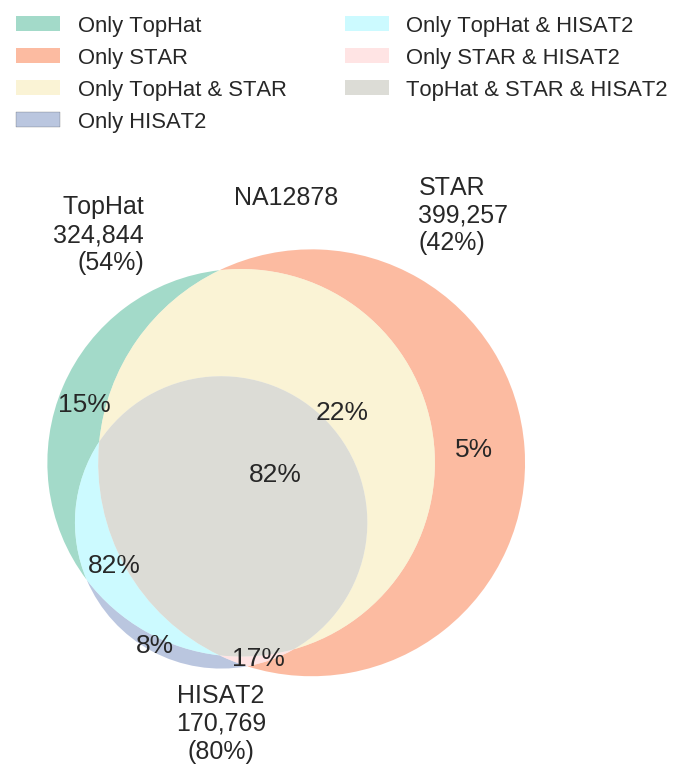

In [18]:
sns.set(style="white",font_scale=2.2)    
fig, ax = plt.subplots(figsize=(10,10))
keys=["r_est","r_est_reliable"]
labels=["% of EST matches","% Reliable EST matches"]
index = np.arange(len(methods))
bar_width = 0.2
opacity = 0.5
my_colors=sns.color_palette("Set2",n_colors=10)
v = venn3(subsets=[intersect_3methods[k]['n_junctions'] for k in range(1,8)], 
          set_labels = ('A','B','C'),ax=ax,alpha=0.6,set_colors=my_colors[0:3])
for c in range(1,8):
    i=c%2
    j=(c/2)%2
    k=(c/4)%2
    v.get_label_by_id('%d%d%d'%(i,j,k)).set_text("%d%%"%(
                                                    intersect_3methods[c]['r_est_reliable']*100))
v.get_label_by_id('A').set_text('TopHat\n%s,%03d\n(%d%%)'%(alignment_stats['Tophat']['n_junctions']/1000,
                                                         alignment_stats['Tophat']['n_junctions']%1000,
                                                     alignment_stats['Tophat']['r_est_reliable']*100))
v.get_label_by_id('B').set_text('STAR\n%s,%03d\n(%d%%)'%(alignment_stats['STAR']['n_junctions']/1000,
                                                    alignment_stats['STAR']['n_junctions']%1000,
                                                     alignment_stats['STAR']['r_est_reliable']*100))
v.get_label_by_id('C').set_text('HISAT2\n%s,%03d\n(%d%%)'%(alignment_stats['HISAT2']['n_junctions']/1000,
                                                      alignment_stats['HISAT2']['n_junctions']%1000,
                                                     alignment_stats['HISAT2']['r_est_reliable']*100))
for labe_id in ["A","B","C"]:
    v.get_label_by_id(labe_id).set_fontsize(25)
ax.set_title(sample,fontsize=25)

for labe_id in ["A","B","C","110","101","111","011"]:
    v.get_patch_by_id(labe_id).set_linewidth(0)

ax.legend(["Only TopHat","Only STAR","Only TopHat & STAR","Only HISAT2",
            "Only TopHat & HISAT2","Only STAR & HISAT2","TopHat & STAR & HISAT2"],bbox_to_anchor=(0, 1.1, 1.2, .3), 
  loc=0,ncol=2,
  mode="expand", borderaxespad=0.,frameon=False)



## Read mapping analysis

['AC', 'AG', 'AT', 'CA', 'CG', 'CT', 'GA', 'GC', 'GT', 'TA', 'TC', 'TG']


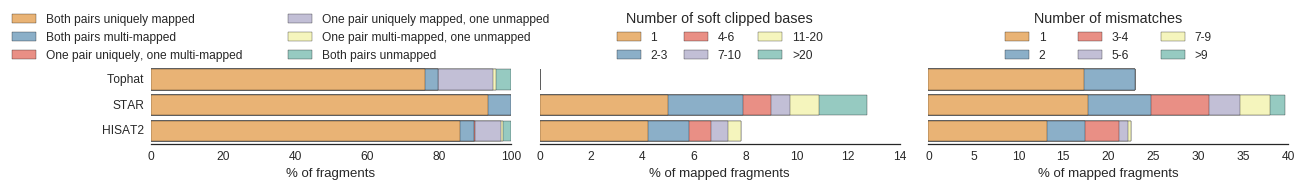

In [19]:
sns.set(style="white",font_scale=1.2)    
colors=[4]
nt=["A","C","G","T"]
etypes=[]
for i in nt:
    for j in nt:
        if i!=j:
            etypes.append(i+j)
print etypes
bin_labels=["Both pairs uniquely mapped","Both pairs multi-mapped", "One pair uniquely, one multi-mapped",
           "One pair uniquely mapped, one unmapped","One pair multi-mapped, one unmapped", "Both pairs unmapped"]
keys=['uniqmap_uniqmap','multimap_multimap',  'uniqmap_multimap', 'uniqmap_unmap', 'multimap_unmap',  'unmap_unmap']
my_colors=sns.color_palette("Set3",n_colors=10)

fig, axes = plt.subplots(1,3,figsize=(17,2))        
ax=axes[0]
res=[]
labels=[]
for method in methods:
    if method not in alignment_stats:
        continue
    if "uniqmap_uniqmap" in alignment_stats[method]: 
        myres=[alignment_stats[method][k]/float(alignment_stats[method]["total"])*100 for k in keys][::-1]
        myres=[sum(myres[i:]) for i in range(len(myres))]
        res.append(myres)
        label=method
        labels.append(label)
my_data=DataFrame(np.array(res),index=labels,columns=bin_labels)
for ii,b in enumerate(bin_labels):
    cg=sns.barplot(data=my_data,x=b,y=labels,label=b, color=my_colors[ii],ax=ax)

ax.set_xlabel("% of fragments")
ax.set_xlim([0,100])
sns.despine(left=True)    
handles, labels = ax.get_legend_handles_labels()
# reverse the order
ax.legend(handles[::-1], labels,bbox_to_anchor=(-0.4, 1, 1.52, .3), 
      loc=0,ncol=2,
      mode="expand", borderaxespad=0.,frameon=False,fontsize=12)
plt.tight_layout()


ax=axes[1]
bin_labels=["1","2-3","4-6","7-10","11-20",">20"]
bins=[1,3,6,10,20,1000]

codes=[4]
res=[]
labels=[]
for method in methods:
    if method not in alignment_stats:
        continue
    if "match_stats" not in alignment_stats[method]:
        continue
    if set(alignment_stats[method]["match_stats"].keys())&set(codes): 
        my_res=[]
        for b in bins[::-1]:
            my_res.append(sum([v for code in set(alignment_stats[method]["match_stats"].keys())&set(codes)
                           for k,v in alignment_stats[method]["match_stats"][code].iteritems() if (
                            k<=b)])/float(sum(alignment_stats[method]["NM"].values()))*100)
        my_res=my_res
        res.append(my_res)
        label=method
        labels.append(label)
    else:
        my_res=[]
        for b in bins:
            my_res.append(0)
        my_res=my_res
        res.append(my_res)
        label=method
        labels.append(label)
            
my_data=DataFrame(np.array(res),index=labels,columns=bin_labels)
for ii,b in enumerate(bin_labels):
    cg=sns.barplot(data=my_data,x=b,y=labels,label=b, color=my_colors[ii],ax=ax)
    
ax.set_yticklabels([])

ax.set_xlabel("% of mapped fragments")
sns.despine(left=True)    
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels,bbox_to_anchor=(0.2, 1, .6, .3), 
      loc=0,ncol=3,
      mode="expand", borderaxespad=0.,frameon=False,fontsize=12, title="Number of soft clipped bases")
plt.tight_layout()




ax=axes[2]

bin_labels=["1","2","3-4","5-6","7-9",">9"]
bins=[1,2,4,6,9,1000]
res=[]
labels=[]
for method in methods:
    if method not in alignment_stats:
        continue
    if "NM" not in alignment_stats[method]:
        continue
    my_res=[]
    for b in bins[::-1]:
        my_res.append(sum([v/float(sum(alignment_stats[method]["NM"].values()))*100
                       for k,v in alignment_stats[method]["NM"].iteritems() if (
                        0<k<=b)]))
    my_res=my_res
    res.append(my_res)
    label=method
    labels.append(label)
my_data=DataFrame(np.array(res),index=labels,columns=bin_labels)
for ii,b in enumerate(bin_labels):
    cg=sns.barplot(data=my_data,x=b,y=labels,label=b, color=my_colors[ii],ax=ax)
    
ax.set_yticklabels([])

ax.set_xlabel("% of mapped fragments")
sns.despine(left=True)    
handles, labels = ax.get_legend_handles_labels()
# reverse the order
ax.legend(handles[::-1], labels,bbox_to_anchor=(0.2, 1, 0.6, .3), 
      loc=0,ncol=3,
      mode="expand", borderaxespad=0.,frameon=False,fontsize=12,title="Number of mismatches")
plt.tight_layout()

